In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt


import math
import time
from dataclasses import dataclass
import os

import numpy as np
import re


In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
train_model = True #@param {type: "boolean"}

In [108]:
# Dataset specific parameters
folder_path = "/content/drive/MyDrive/eCAADe2025 Workshop"#@param {type: "string"}

dataset_folder = folder_path + "/datasets/point_cloud_dataset"

number_of_pc_points = 250  #@param

save_model = True

model_save_path = folder_path + "/_models"
# create save_model_location if it doens not exist
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

save_model_name = "PC_250" #@param {type: "string"}
model_name = save_model_name

save_geo_path = folder_path + "/_geometries/pc"
if not os.path.exists(save_geo_path):
    os.makedirs(save_geo_path)
save_geo_name = "PC_Polysurface" #@param {type: "string"}
geo_export_name = save_geo_name

train_test_split = 0.90 #@param {type: "number"}
batch_size = 32 #@param {type: "number"}

# Hyper paramters

# ⚙️ Suggested Hyperparameters for Small Point Cloud Datasets

*   **latent_dim** → 32  
    * Small latent space is enough to capture structure without overfitting.

*   **enc_widths** → (64, 128, 256)  
    * Lightweight encoder that can still capture useful features.

*   **dec_widths** → (256, 128)  
    * Simple decoder for reconstructing small point clouds.

*   **query_dim** → 32  
    * Default value works well, higher not needed for small datasets.

*   **beta_start** — starting weight on the KL divergence term.  
    * Keeps KL influence small at the beginning so the model can first focus on learning good reconstructions.  
    * Typical: 5e-4  

*   **beta_end** — final weight on the KL divergence term after warm-up.  
    * Determines how strongly the latent space is regularized once training has progressed.  
    * Typical: 0.003 for small datasets

*   **lr (learning rate)** → 5e-4  
    * Slightly lower than default for more stable training.

*   **weight_decay** → 1e-6  
    * Small regularization to avoid overfitting.

*   **num_epochs** → 50–100  
    * Enough to converge without heavy overfitting.

*   **grad_clip** → 1.0  
    * Prevents exploding gradients; safe default.

*   **amp** → True (if using GPU)  
    * Mixed precision speeds up training without quality loss.

*   **eval_batches** → 10  
    * Quick validation check; set to None for full evaluation if dataset is tiny.

*   **seed** → 42  
    * For reproducibility.

*   **fix_seed** → True  
    * For reproducibility.


In [92]:
# ======================================================================
# Hyperparameters – tweak here
# ======================================================================
@dataclass
class HParams:
    latent_dim: int = 64                 #@param {type: "number"}

    # shared-MLP widths for encoder
    enc_widths: tuple = (64, 128, 256) #@param

    # MLP widths for decoder (after [z||q])
    dec_widths: tuple = (256, 256, 128)  #@param

    # size of per-point query embedding
    query_dim: int = 32  #@param {type: "number"}
    # β for the KL term (β-VAE)
    beta_start=5e-4 #@param {type: "number"}
    beta_end=3e-3    #@param {type: "number"}
    beta_kl: float = 0.001
    lr: float = 5e-4 #@param {type: "number"}
    weight_decay: float =  0.000001 #@param {type: "number"}
    num_epochs: int = 100 #@param {type: "number"}

    # 0 or None to disable
    grad_clip: float = 1.0   #@param {type: "number"}

     # automatic mixed precision
    amp: bool = True  #@param {type: "boolean"}

    # how many test batches to evaluate (None = all)
    eval_batches: int = 5 #@param {type: "number"}

     # reproducibility
    seed: int = 42             #@param {type: "number"}

hp = HParams()



# Reproducibility

fix_seed = True#@param {type: "boolean"}
if fix_seed:
  torch.manual_seed(hp.seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(hp.seed)


In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("sellected device", device)
if str(device) == 'cuda':
    print("CUDA is available")
else:
    print("CUDA is not available - choose a GPU Hardware to speed up AI training")

sellected device cuda
CUDA is available


In [94]:
class VoxelDataset(Dataset):
    def __init__(self, folder_path, expected_shape):
        self.folder_path = folder_path
        self.expected_shape = expected_shape
        self.file_paths = []
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith('.npy'):
                    file_path = os.path.join(root, file)
                    item = np.load(file_path)
                    #print(f"Loaded file {file} with shape {item.shape}")
                    if item.shape == expected_shape:
                        self.file_paths.append(file_path)
                    else:
                        print(f"Skipping file {file} due to unexpected shape: {item.shape}")


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        item = np.load(file_path)
        return torch.tensor(item, dtype=torch.float32)

In [95]:
def visualize_point_cloud(pc_tensor, color='b'):
    if isinstance(pc_tensor, torch.Tensor):
        pc_tensor = pc_tensor.cpu().detach().numpy()

    # Assuming the input shape is (number of points, 3)
    # If the shape is (3, number of points), transpose it
    if pc_tensor.shape[0] == 3 and pc_tensor.shape[1] != 3:
        pc_tensor = pc_tensor.T


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = pc_tensor[:, 0]
    y = pc_tensor[:, 1]
    z = pc_tensor[:, 2]

    ax.scatter(x, y, z, c=color, marker='o', s=1) # Added s=1 for smaller points

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point Cloud Visualization')

    plt.show()


In [96]:
def plot_point_cloud_histograms(pc_tensor):
    if isinstance(pc_tensor, torch.Tensor):
        pc_tensor = pc_tensor.cpu().detach().numpy()

    # Ensure the shape is (number of points, 3)
    if pc_tensor.shape[0] == 3 and pc_tensor.shape[1] != 3:
        pc_tensor = pc_tensor.T

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    num_bins = 20
    axes[0].hist(pc_tensor[:, 0], bins=num_bins, color='red')
    axes[0].set_title('X Coordinate Distribution')
    axes[0].set_xlabel('X Value')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(pc_tensor[:, 1], bins=num_bins, color="green")
    axes[1].set_title('Y Coordinate Distribution')
    axes[1].set_xlabel('Y Value')
    axes[1].set_ylabel('Frequency')

    axes[2].hist(pc_tensor[:, 2], bins=num_bins, color = "blue")
    axes[2].set_title('Z Coordinate Distribution')
    axes[2].set_xlabel('Z Value')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

Shape of Data torch.Size([32, 3, 250])
Data type:  torch.float32
Number of batches in Training Set:  85


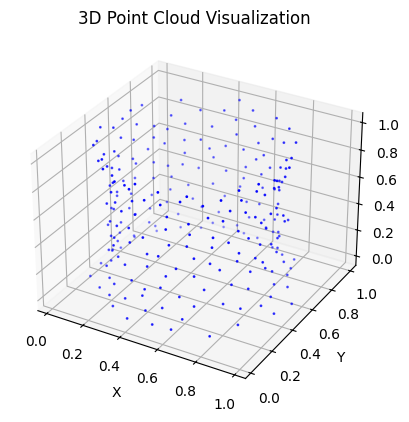

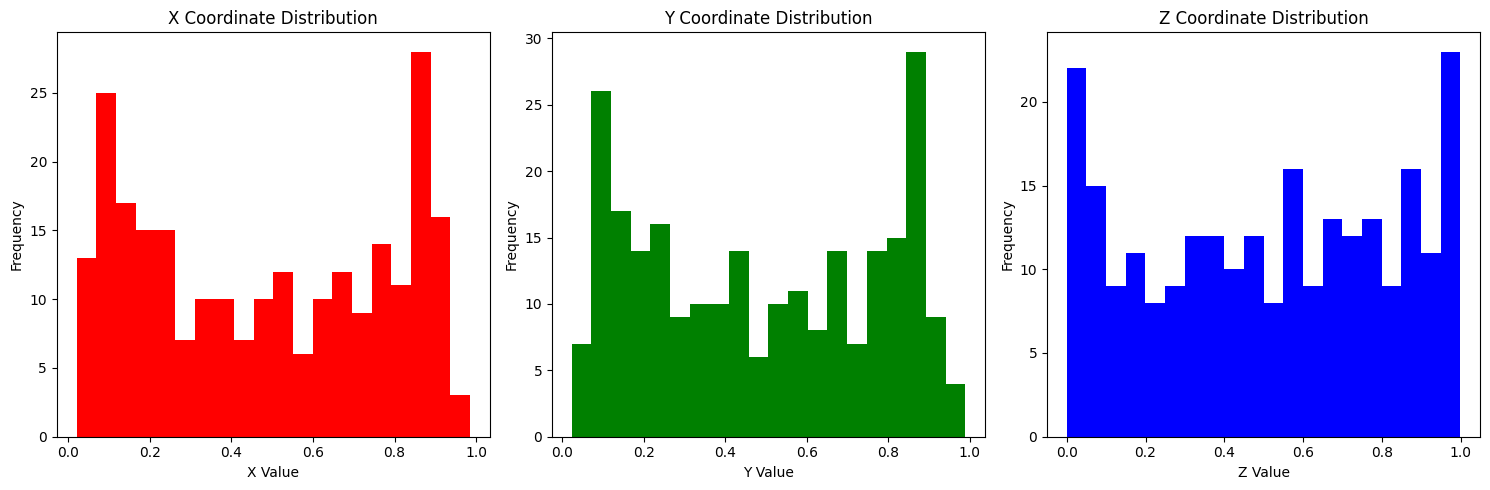

Number of batches in Test Set:  10


In [97]:
except_data_shape = (3, number_of_pc_points)
dataset = VoxelDataset(dataset_folder, except_data_shape)

# Split the dataset into training and test sets
train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
for batch_data in train_dataloader:
    print("Shape of Data",batch_data.shape)  # Should print torch.Size([batch_size, 3, 1500])
    print("Data type: ", batch_data.dtype)  # Should print torch.float32
    print("Number of batches in Training Set: ", len(train_dataloader))
    visualize_point_cloud(batch_data[0])
    plot_point_cloud_histograms(batch_data[0])
    break


for batch_data in test_dataloader:
    print("Number of batches in Test Set: ", len(test_dataloader))
    break

# Chamfer Distance & Utilities

In [98]:
@torch.no_grad()
def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """Reparameterization trick."""
    std = (0.5 * logvar).exp()
    eps = torch.randn_like(std)
    return mu + eps * std

def chamfer_distance(x, y, squared: bool = True):
    """
    x: (B, Nx, 3)
    y: (B, Ny, 3)
    Returns mean Chamfer distance over batch.
    Uses torch.cdist; for memory safety Nx,Ny up to ~2k are fine on modern GPUs.
    """
    # Pairwise distances (B, Nx, Ny)
    d = torch.cdist(x, y, p=2)  # Euclidean
    if squared:
        d = d ** 2

    # For each point in x, distance to nearest in y
    x2y = d.min(dim=2)[0]  # (B, Nx)
    # For each point in y, distance to nearest in x
    y2x = d.min(dim=1)[0]  # (B, Ny)

    cd = x2y.mean(dim=1) + y2x.mean(dim=1)  # (B,)
    return cd.mean()  # scalar

def make_point_queries(n_points: int, batch_size: int, dim: int, device: torch.device):
    """
    Generate per-point query embeddings (variable N supported).
    Here we use a deterministic sinusoidal embedding of normalized indices 0..N-1.
    Shape: (B, N, dim)
    """
    idx = torch.arange(n_points, device=device).float()  # (N,)
    t = (idx + 0.5) / n_points  # (N,) in (0,1]

    # Positional (Fourier) features
    freqs = torch.arange(dim // 2, device=device).float()  # (dim/2,)
    freqs = (2.0 ** freqs) * math.pi  # spread frequencies exponentially
    angles = t[:, None] * freqs[None, :]  # (N, dim/2)
    emb = torch.cat([angles.sin(), angles.cos()], dim=-1)  # (N, dim)

    if emb.shape[-1] < dim:
        # pad if dim is odd
        emb = F.pad(emb, (0, dim - emb.shape[-1]))

    emb = emb[None, ...].repeat(batch_size, 1, 1)  # (B, N, dim)
    return emb


# PointNet-style VAE (variable-N decoder)

In [99]:
class SharedMLP(nn.Module):
    """1×1 MLP applied per point with BatchNorm and ReLU."""
    def __init__(self, in_dim, widths):
        super().__init__()
        layers = []
        last = in_dim
        for w in widths:
            layers += [nn.Conv1d(last, w, kernel_size=1, bias=False),
                       nn.BatchNorm1d(w),
                       nn.ReLU(inplace=True)]
            last = w
        self.net = nn.Sequential(*layers)

    def forward(self, x):  # x: (B, C_in, N)
        return self.net(x) # (B, C_out, N)


class Encoder(nn.Module):
    def __init__(self, enc_widths=(64, 128, 256), latent_dim=64):
        super().__init__()
        self.mlp = SharedMLP(3, enc_widths)  # input: (B,3,N)
        feat_dim = enc_widths[-1]
        self.mu = nn.Linear(feat_dim, latent_dim)
        self.logvar = nn.Linear(feat_dim, latent_dim)

    def forward(self, x):  # x: (B,3,N)
        feat = self.mlp(x)              # (B, F, N)
        global_feat = torch.max(feat, dim=2).values  # (B, F)
        mu = self.mu(global_feat)       # (B, latent)
        logvar = self.logvar(global_feat)
        return mu, logvar


class Decoder(nn.Module):
    """
    Flexible decoder: generates N points given latent z and N per-point queries.
    Input:
      z: (B, latent)
      queries: (B, N, query_dim)
    Output:
      pts: (B, N, 3)
    """
    def __init__(self, latent_dim=64, query_dim=32, widths=(256, 256, 128)):
        super().__init__()
        layers = []
        in_dim = latent_dim + query_dim
        last = in_dim
        for w in widths:
            layers += [nn.Linear(last, w), nn.ReLU(inplace=True)]
            last = w
        layers += [nn.Linear(last, 3)]
        self.mlp = nn.Sequential(*layers)

    def forward(self, z, queries):
        B, N, _ = queries.shape
        z_expand = z[:, None, :].expand(B, N, z.shape[-1])   # (B, N, latent)
        h = torch.cat([z_expand, queries], dim=-1)           # (B, N, latent+query)
        out = self.mlp(h)                                    # (B, N, 3)
        return out


class PointCloudVAE(nn.Module):
    def __init__(self, hp):
        super().__init__()
        self.encoder = Encoder(hp.enc_widths, hp.latent_dim)
        self.decoder = Decoder(hp.latent_dim, hp.query_dim, hp.dec_widths)

    def forward(self, x3n):
        """
        x3n: (B, 3, N)
        returns: recon (B, N, 3), mu (B,D), logvar (B,D)
        """
        mu, logvar = self.encoder(x3n)
        z = reparameterize(mu, logvar)

        B, _, N = x3n.shape
        queries = make_point_queries(N, B, dim=hp.query_dim, device=x3n.device)
        recon = self.decoder(z, queries)  # (B, N, 3)
        return recon, mu, logvar

model = PointCloudVAE(hp).to(device)
print(model)
print("Trainable params:", count_params(model))


PointCloudVAE(
  (encoder): Encoder(
    (mlp): SharedMLP(
      (net): Sequential(
        (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
        (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
    )
    (mu): Linear(in_features=256, out_features=64, bias=True)
    (logvar): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (mlp): Sequential(
      (0): Linear(in_features=96, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_f

# Optimizer, Loss Wrapper, Train / Eval Steps

In [100]:
# Optimizer & (optional) scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=hp.lr, weight_decay=hp.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=hp.num_epochs)

scaler = torch.amp.GradScaler("cuda", enabled=hp.amp and device.type == "cuda")

def kl_divergence(mu, logvar):
    # KL(q(z|x) || N(0,I)) = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def train_one_epoch(model, dataloader, optimizer, scaler):
    model.train()
    total_cd, total_kl, total_loss, n_batches = 0.0, 0.0, 0.0, 0
    start = time.time()

    for batch in dataloader:
        # Expect: batch shape (B, 3, N), dtype float32
        x = batch.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=hp.amp and device.type == "cuda"):
            recon, mu, logvar = model(x)                    # recon: (B, N, 3)
            # Input x is (B,3,N) -> to (B,N,3) for Chamfer
            x_n3 = x.transpose(1, 2).contiguous()           # (B, N, 3)
            cd = chamfer_distance(recon, x_n3, squared=True)
            kl = kl_divergence(mu, logvar)
            loss = cd + hp.beta_kl * kl

        scaler.scale(loss).backward()
        if hp.grad_clip and hp.grad_clip > 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), hp.grad_clip)
        scaler.step(optimizer)
        scaler.update()

        total_cd += cd.item()
        total_kl += kl.item()
        total_loss += loss.item()
        n_batches += 1

    dur = time.time() - start
    return {
        "loss": total_loss / n_batches,
        "cd": total_cd / n_batches,
        "kl": total_kl / n_batches,
        "time": dur,
    }

@torch.no_grad()
def eval_epoch(model, dataloader, max_batches=None):
    model.eval()
    total_cd, total_kl, total_loss, n_batches = 0.0, 0.0, 0.0, 0
    for i, batch in enumerate(dataloader):
        if (max_batches is not None) and (i >= max_batches):
            break
        x = batch.to(device)
        recon, mu, logvar = model(x)
        x_n3 = x.transpose(1, 2).contiguous()
        cd = chamfer_distance(recon, x_n3, squared=True)
        kl = kl_divergence(mu, logvar)
        loss = cd + hp.beta_kl * kl
        total_cd += cd.item()
        total_kl += kl.item()
        total_loss += loss.item()
        n_batches += 1
    return {
        "loss": total_loss / n_batches,
        "cd": total_cd / n_batches,
        "kl": total_kl / n_batches,
    }


# Training Loop

In [101]:
warmup_epochs = int(hp.num_epochs*0.2)
def beta_schedule_linear(epoch, warmup_epochs=warmup_epochs, beta_start=hp.beta_start, beta_end=hp.beta_end):
    t = min(max(epoch, 0), warmup_epochs)
    return beta_start + (beta_end - beta_start) * (t / float(warmup_epochs))


In [102]:
# ---- OPTIONAL: only if you want to capture curves for plotting ----
history = {
    "train_loss": [], "train_cd": [], "train_kl": [],
    "val_loss": [], "val_cd": [], "val_kl": [],
    "lr": []
}

best_val = float('inf')
best_state = None

for epoch in range(1, hp.num_epochs + 1):
    current_beta = beta_schedule_linear(epoch-1)
    hp.beta_kl = current_beta  # update dynamically
    tr = train_one_epoch(model, train_dataloader, optimizer, scaler)
    val = eval_epoch(model, test_dataloader, max_batches=hp.eval_batches)

    # record history BEFORE stepping the scheduler
    history["train_loss"].append(tr["loss"])
    history["train_cd"].append(tr["cd"])
    history["train_kl"].append(tr["kl"])
    history["val_loss"].append(val["loss"])
    history["val_cd"].append(val["cd"])
    history["val_kl"].append(val["kl"])
    # current LR from optimizer
    history["lr"].append(optimizer.param_groups[0]["lr"])

    scheduler.step()

    print(f"Epoch {epoch:03d} | "
          f"train_loss {tr['loss']:.5f} (cd {tr['cd']:.5f}, kl {tr['kl']:.5f}) | "
          f"val_loss {val['loss']:.5f} (cd {val['cd']:.5f}, kl {val['kl']:.5f}) | "
          f"{tr['time']:.1f}s | lr {history['lr'][-1]:.2e}")

    if val['loss'] < best_val:
        best_val = val['loss']
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

# Load best weights back (optional but recommended)
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model with val_loss={best_val:.5f}")


Epoch 001 | train_loss 0.12058 (cd 0.10840, kl 24.35706) | val_loss 0.02917 (cd 0.02712, kl 4.10069) | 6.3s | lr 5.00e-04
Epoch 002 | train_loss 0.02380 (cd 0.02196, kl 2.94585) | val_loss 0.01983 (cd 0.01808, kl 2.79228) | 6.5s | lr 5.00e-04
Epoch 003 | train_loss 0.01863 (cd 0.01703, kl 2.12667) | val_loss 0.01647 (cd 0.01482, kl 2.20314) | 5.9s | lr 5.00e-04
Epoch 004 | train_loss 0.01635 (cd 0.01487, kl 1.69063) | val_loss 0.01557 (cd 0.01403, kl 1.76794) | 5.7s | lr 4.99e-04
Epoch 005 | train_loss 0.01517 (cd 0.01371, kl 1.46344) | val_loss 0.01491 (cd 0.01315, kl 1.75598) | 5.9s | lr 4.98e-04
Epoch 006 | train_loss 0.01438 (cd 0.01291, kl 1.30928) | val_loss 0.01354 (cd 0.01222, kl 1.17975) | 5.9s | lr 4.97e-04
Epoch 007 | train_loss 0.01370 (cd 0.01222, kl 1.18471) | val_loss 0.01329 (cd 0.01194, kl 1.08474) | 5.7s | lr 4.96e-04
Epoch 008 | train_loss 0.01326 (cd 0.01176, kl 1.09593) | val_loss 0.01305 (cd 0.01147, kl 1.14334) | 5.8s | lr 4.94e-04
Epoch 009 | train_loss 0.01317 

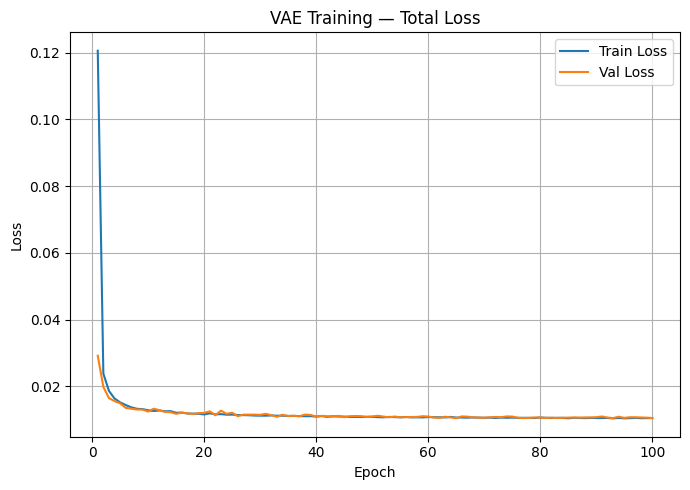

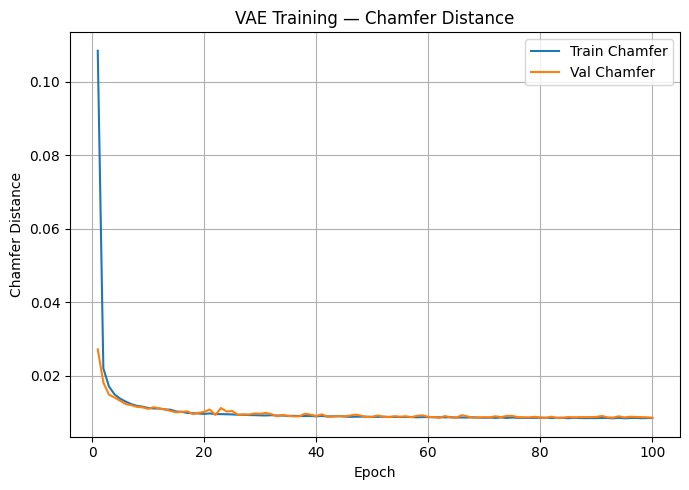

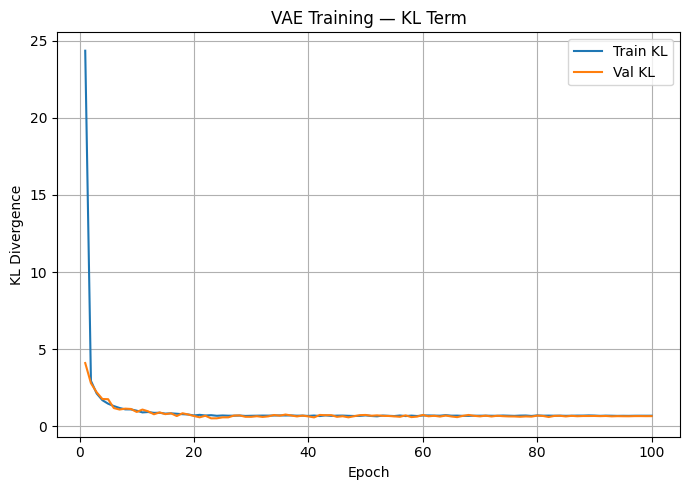

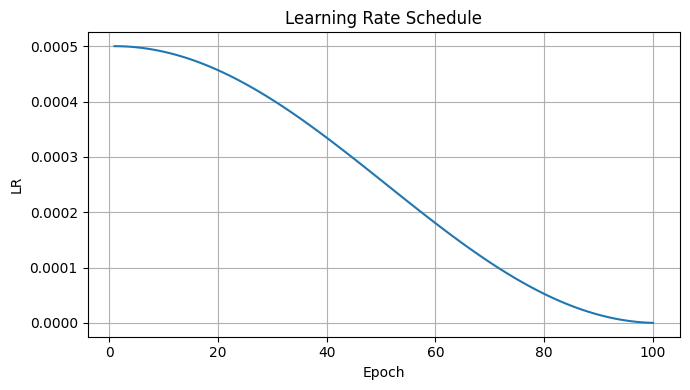

In [103]:
import matplotlib.pyplot as plt
import math

# Basic checks
assert "history" in globals(), "No 'history' dict found. Use the optional training loop above to record it."
required_keys = ["train_loss","train_cd","train_kl","val_loss","val_cd","val_kl","lr"]
missing = [k for k in required_keys if k not in history]
assert not missing, f"'history' is missing keys: {missing}"

epochs = range(1, len(history["train_loss"]) + 1)

# 1) Total loss
plt.figure(figsize=(7,5))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training — Total Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Chamfer & KL (separate y-scales for readability)
plt.figure(figsize=(7,5))
plt.plot(epochs, history["train_cd"], label="Train Chamfer")
plt.plot(epochs, history["val_cd"], label="Val Chamfer")
plt.xlabel("Epoch")
plt.ylabel("Chamfer Distance")
plt.title("VAE Training — Chamfer Distance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs, history["train_kl"], label="Train KL")
plt.plot(epochs, history["val_kl"], label="Val KL")
plt.xlabel("Epoch")
plt.ylabel("KL Divergence")
plt.title("VAE Training — KL Term")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Learning rate (if scheduler used)
plt.figure(figsize=(7,4))
plt.plot(epochs, history["lr"], label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.tight_layout()
plt.show()


# Qualitative Reconstructions on Test Set

Example 1 | N=250 | batch dtype=torch.float32
— Ground truth —


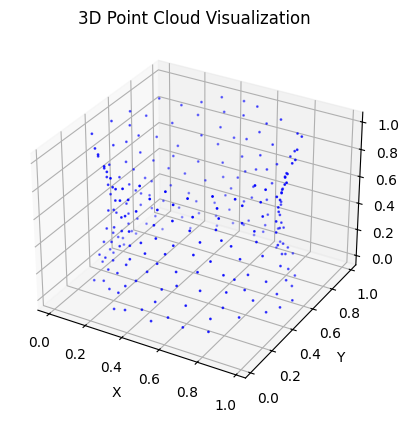

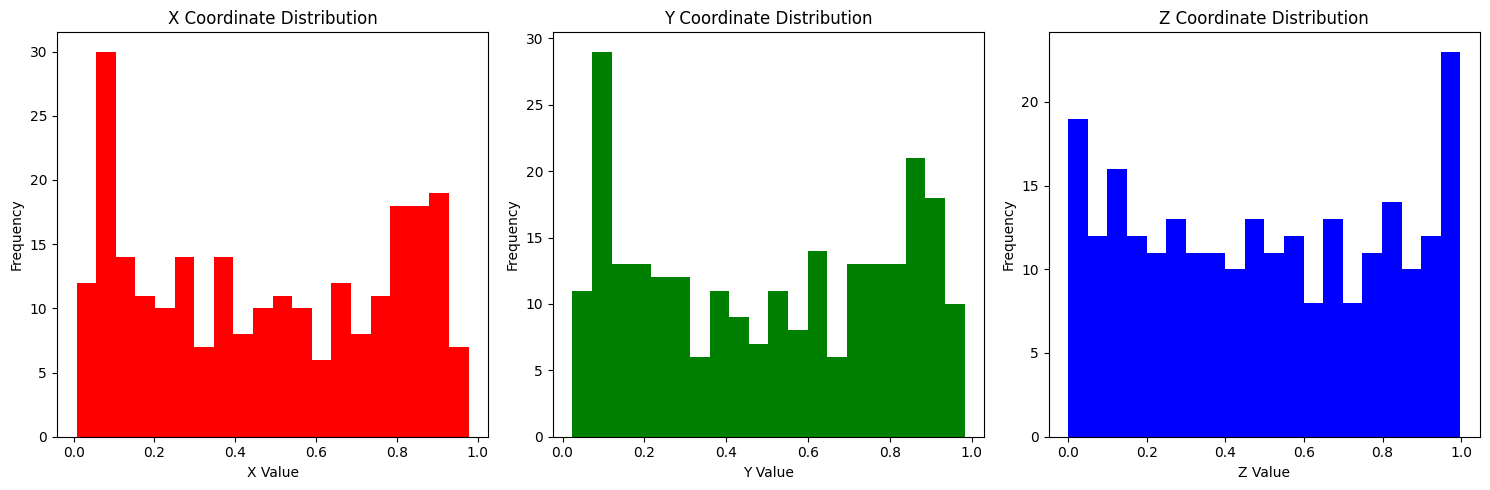

— Reconstruction —


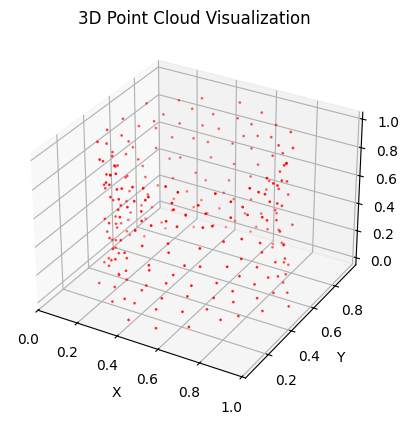

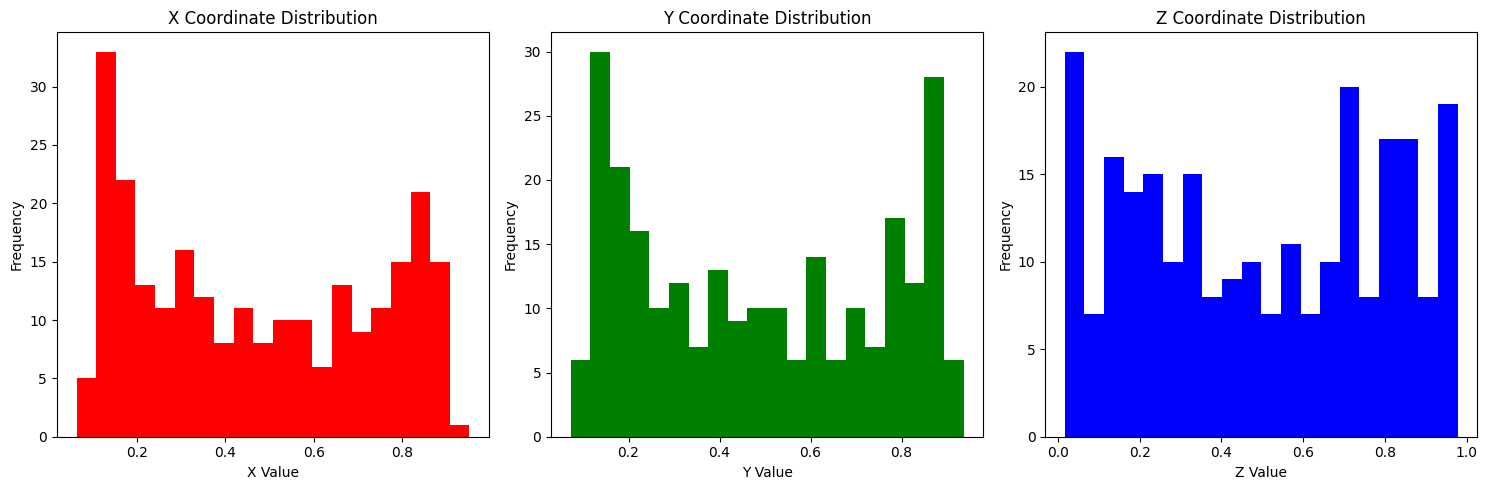

Example 2 | N=250 | batch dtype=torch.float32
— Ground truth —


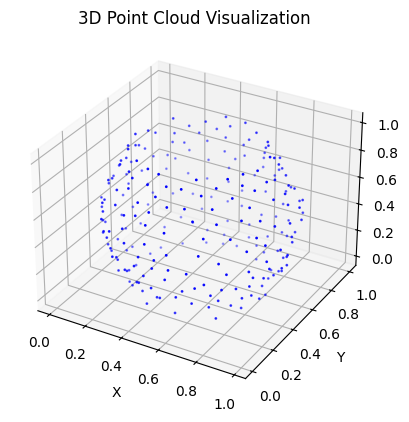

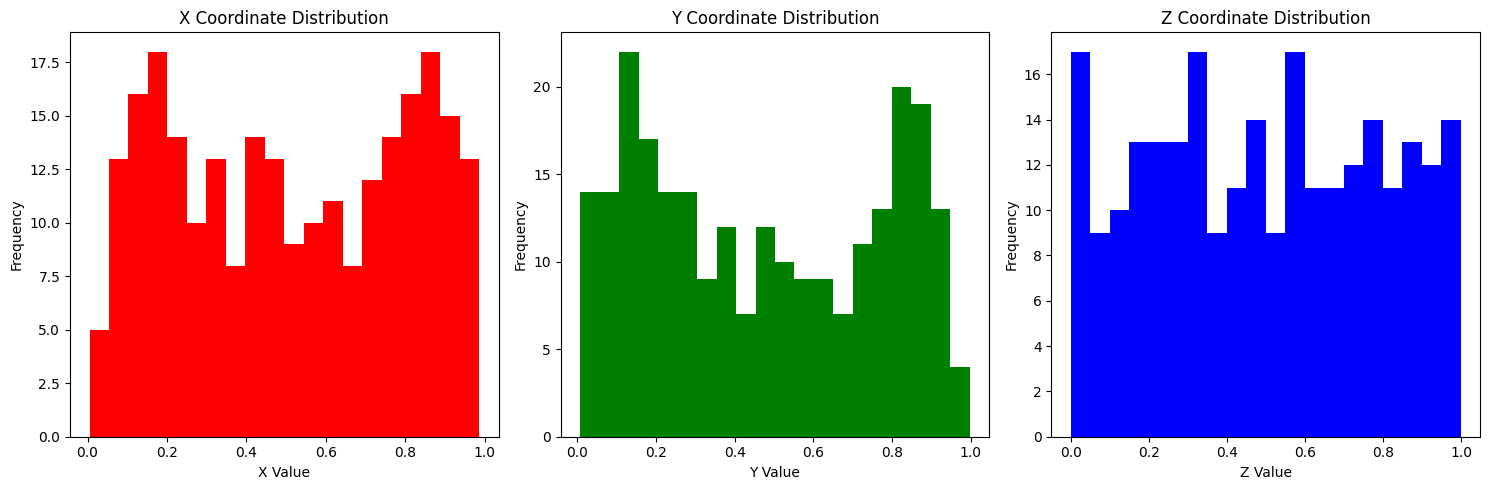

— Reconstruction —


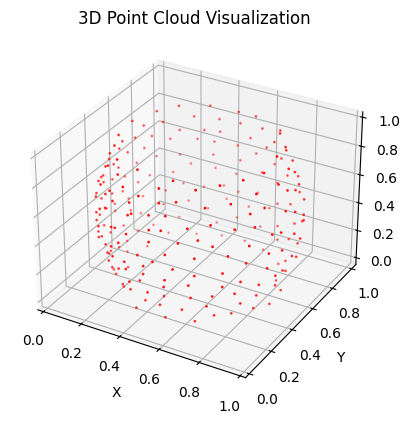

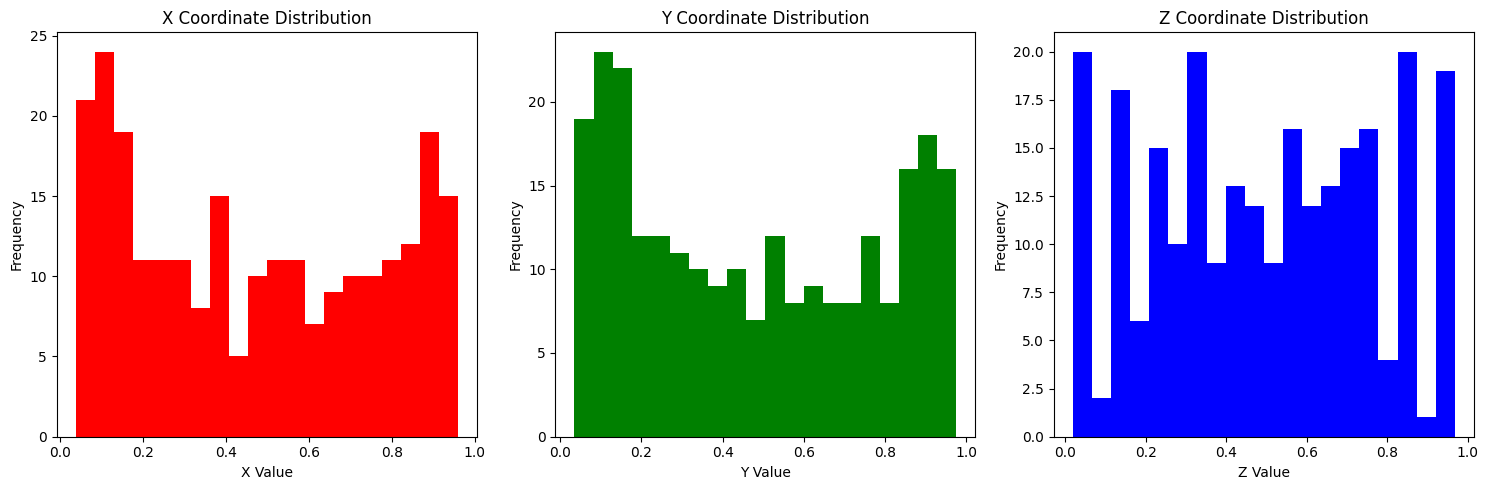

Example 3 | N=250 | batch dtype=torch.float32
— Ground truth —


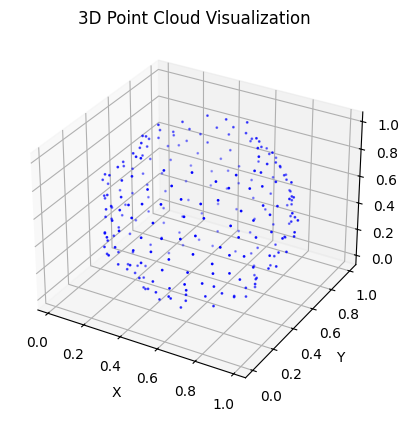

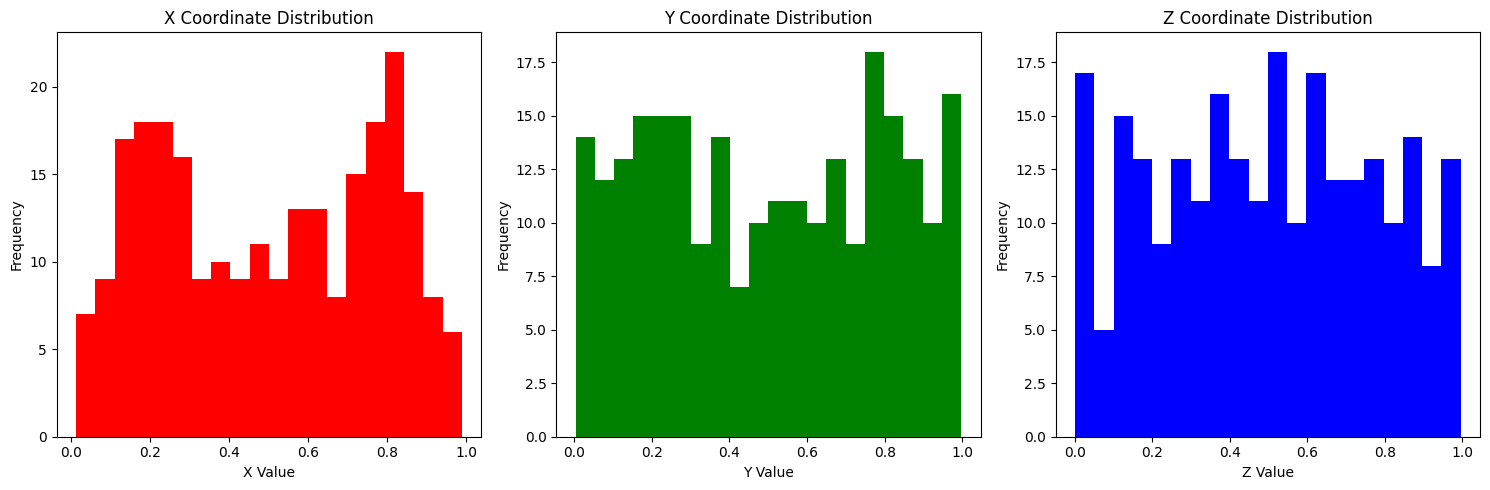

— Reconstruction —


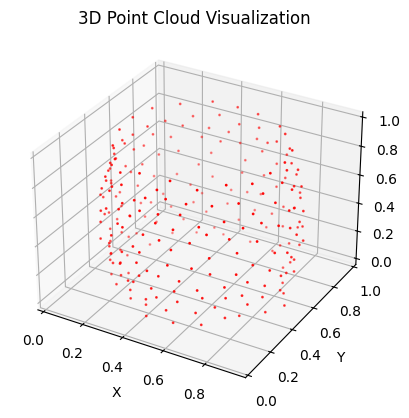

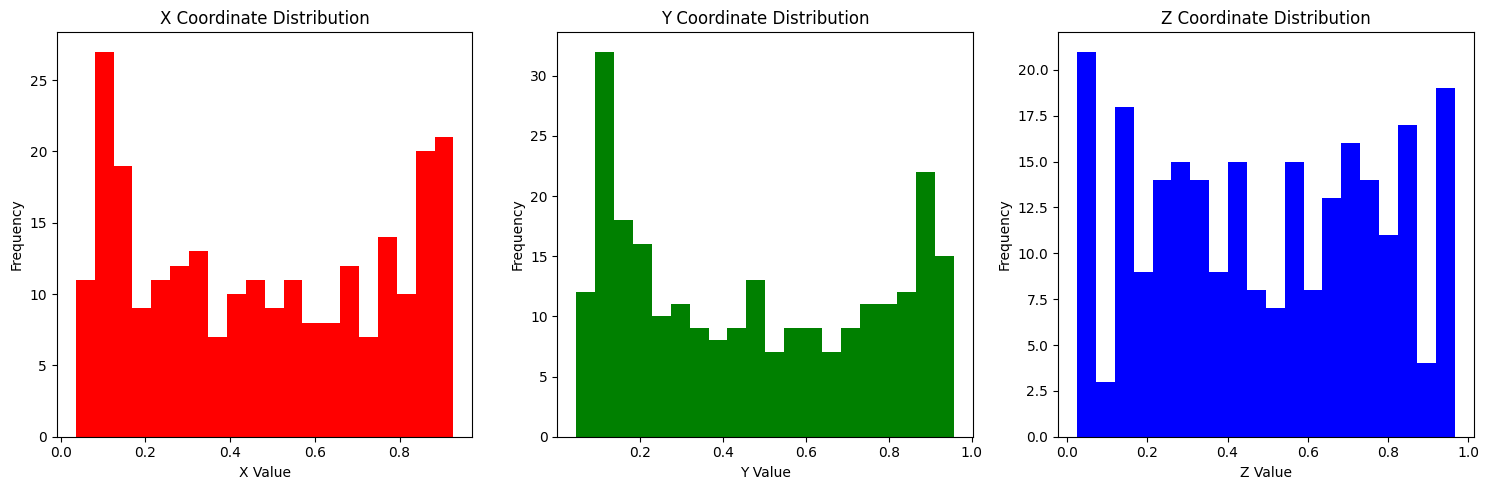

Mean Chamfer (over 1 test batches): 0.009797


In [104]:
@torch.no_grad()
def reconstruct_batch(model, batch_3n):
    model.eval()
    x = batch_3n.to(device)               # (B, 3, N) on device for the model
    recon, _, _ = model(x)                # recon: (B, N, 3) on device
    recon_3n = recon.transpose(1, 2).contiguous().cpu()  # move to CPU for viz
    return recon_3n

# Show a few reconstructions
num_examples_to_show = 3
shown = 0
avg_cd = 0.0
count = 0

for batch in test_dataloader:
    B, C, N = batch.shape
    recon = reconstruct_batch(model, batch)   # (B, 3, N) on CPU

    # Compute Chamfer on CPU for consistency
    with torch.no_grad():
        recon_n3 = recon.transpose(1, 2).contiguous()     # (B, N, 3) CPU
        gt_n3 = batch.transpose(1, 2).contiguous().cpu()  # (B, N, 3) CPU
        cd = chamfer_distance(recon_n3, gt_n3, squared=True).item()
    avg_cd += cd
    count += 1

    # Visualize a few samples (expects (3, N) tensors)
    for i in range(min(num_examples_to_show - shown, B)):
        print(f"Example {shown+1} | N={N} | batch dtype={batch.dtype}")
        print("— Ground truth —")
        visualize_point_cloud(batch[i].cpu())               # (3, N)
        plot_point_cloud_histograms(batch[i].cpu())

        print("— Reconstruction —")
        visualize_point_cloud(recon[i], color="red")                     # (3, N) CPU
        plot_point_cloud_histograms(recon[i])

        shown += 1
        if shown >= num_examples_to_show:
            break
    if shown >= num_examples_to_show:
        break

print(f"Mean Chamfer (over {count} test batches): {avg_cd / max(count,1):.6f}")


# Save/Load Model

In [105]:
# Cell 7 — Save / Load checkpoint with your paths/flags

import os
import torch

def save_checkpoint(model, hp, dir_path, file_stem, extra: dict | None = None, save_flag: bool = True):
    """
    Saves model to {dir_path}/{file_stem}.pt if save_flag is True.
    Also stores hyperparameters and any 'extra' dict entries (e.g., best_val_loss).
    """
    if not save_flag:
        print("ℹ️ save_model=False — skipping save.")
        return None

    os.makedirs(dir_path, exist_ok=True)
    path = os.path.join(dir_path, f"{file_stem}.pt")

    payload = {"state_dict": model.state_dict()}
    if hp is not None:
        payload["hparams"] = vars(hp)
    if extra:
        payload.update(extra)

    torch.save(payload, path)
    print(f"✅ Saved to: {path}")
    return path

def load_checkpoint(path, model, map_location="cpu", strict=True):
    """
    Loads weights from 'path' into 'model'. Returns the loaded checkpoint dict.
    """
    obj = torch.load(path, map_location=map_location)
    model.load_state_dict(obj["state_dict"], strict=strict)
    print("Loaded checkpoint with hparams:", obj.get("hparams", {}))
    return obj

# ---- Save using your variables ----
# Expects these to exist: save_model (bool), model_save_path (str), save_model_name (str)
extra = {}
if "best_val" in globals():
    extra["best_val_loss"] = best_val

_ = save_checkpoint(
    model=model,
    hp=hp,
    dir_path=model_save_path,
    file_stem=save_model_name,
    extra=extra,
    save_flag=save_model
)

# ---- Example: load later ----
# ckpt = load_checkpoint(os.path.join(model_save_path, f"{save_model_name}.pt"), model)


✅ Saved to: /content/drive/MyDrive/eCAADe2025 Workshop/_models/PC_250.pt


# Create new Point Clouds

Generating 10 point clouds with N=250 points each.
[Preview 1] PC_Polysurface_51.npy


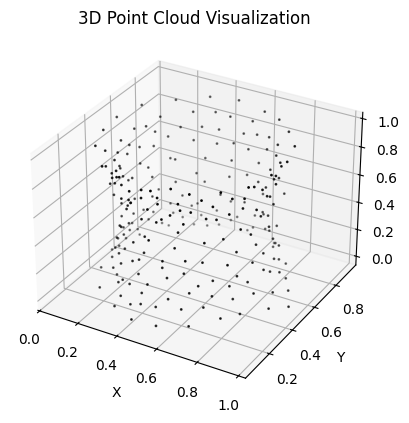

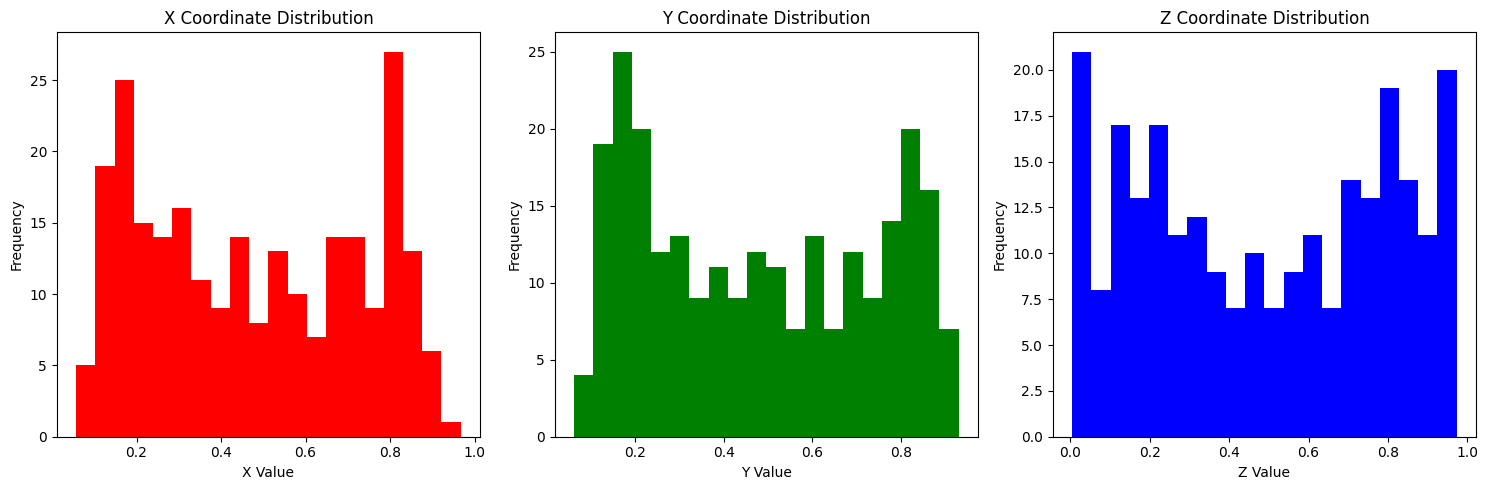

[Preview 2] PC_Polysurface_52.npy


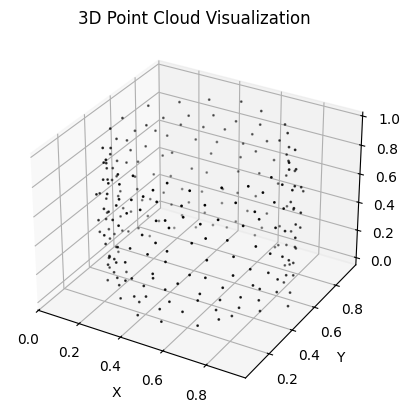

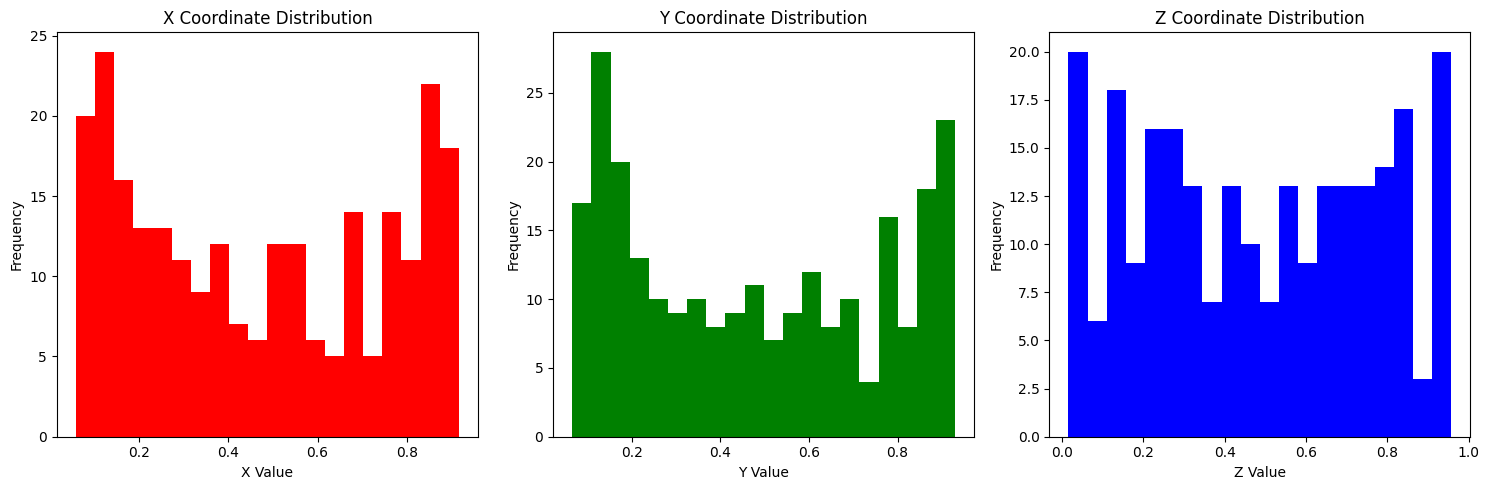

[Preview 3] PC_Polysurface_53.npy


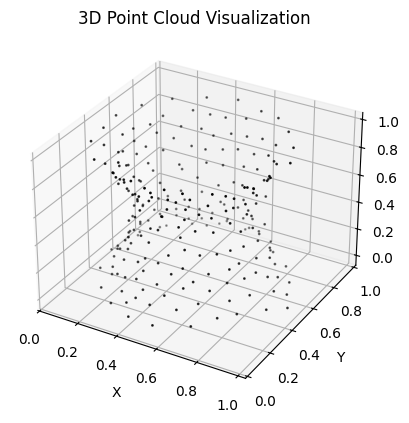

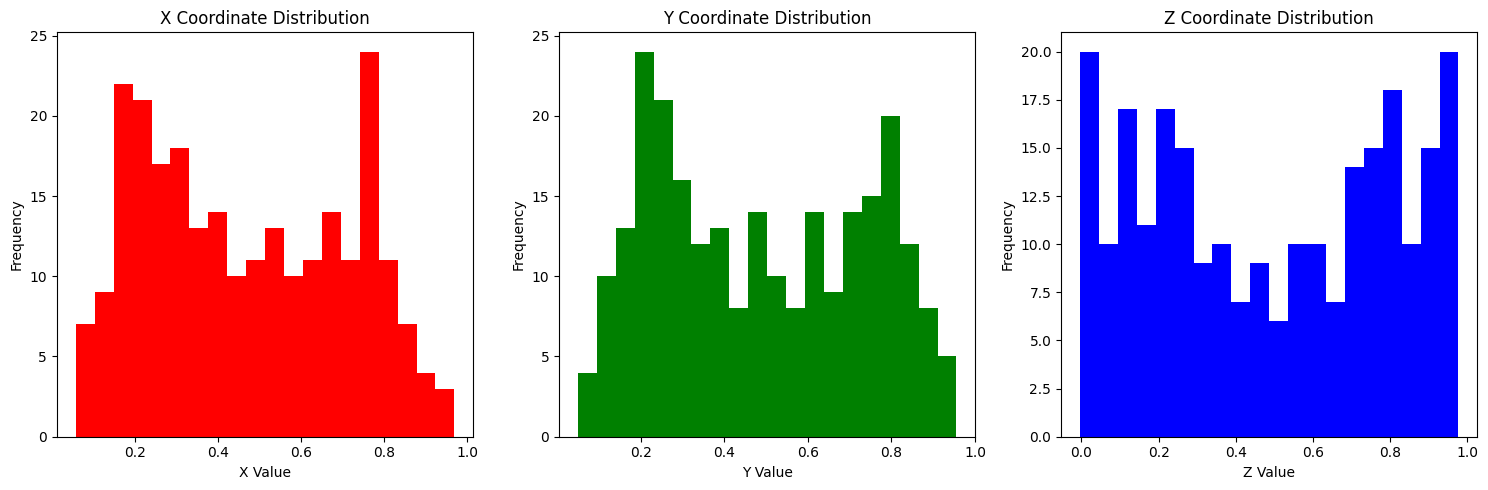

[Preview 4] PC_Polysurface_54.npy


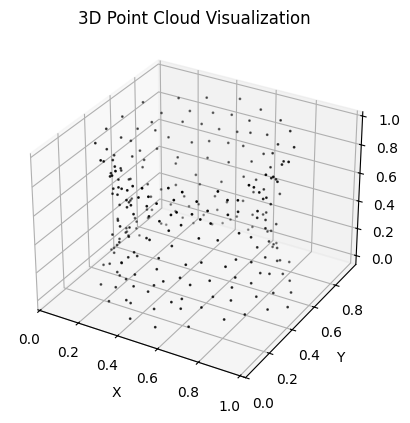

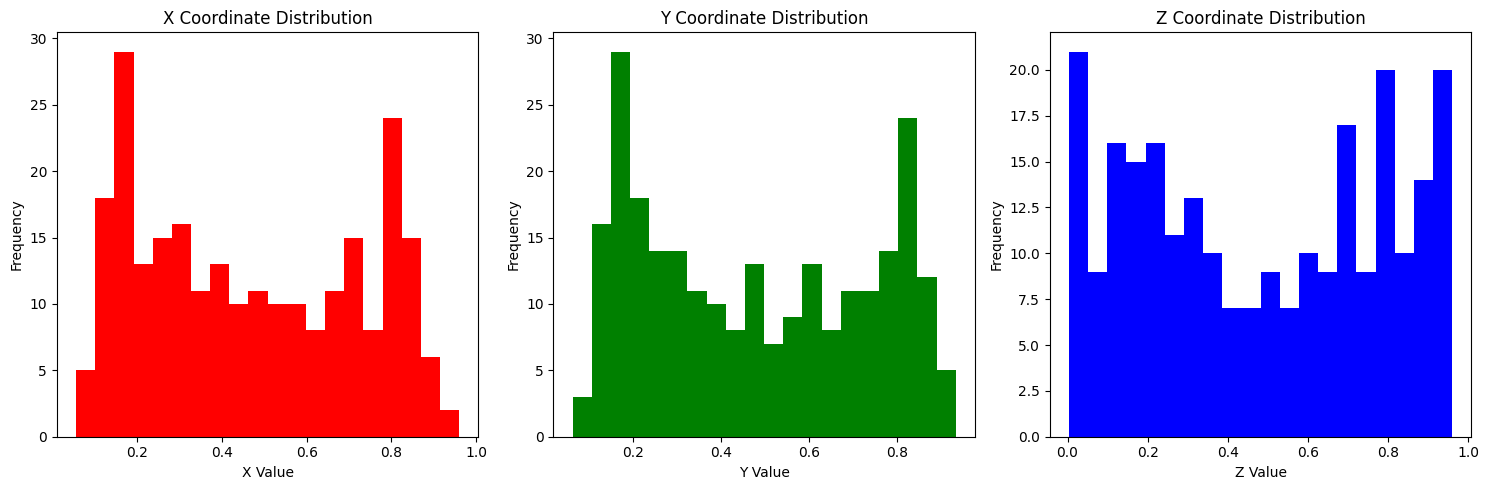

[Preview 5] PC_Polysurface_55.npy


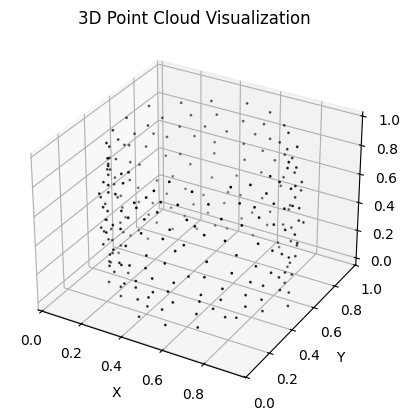

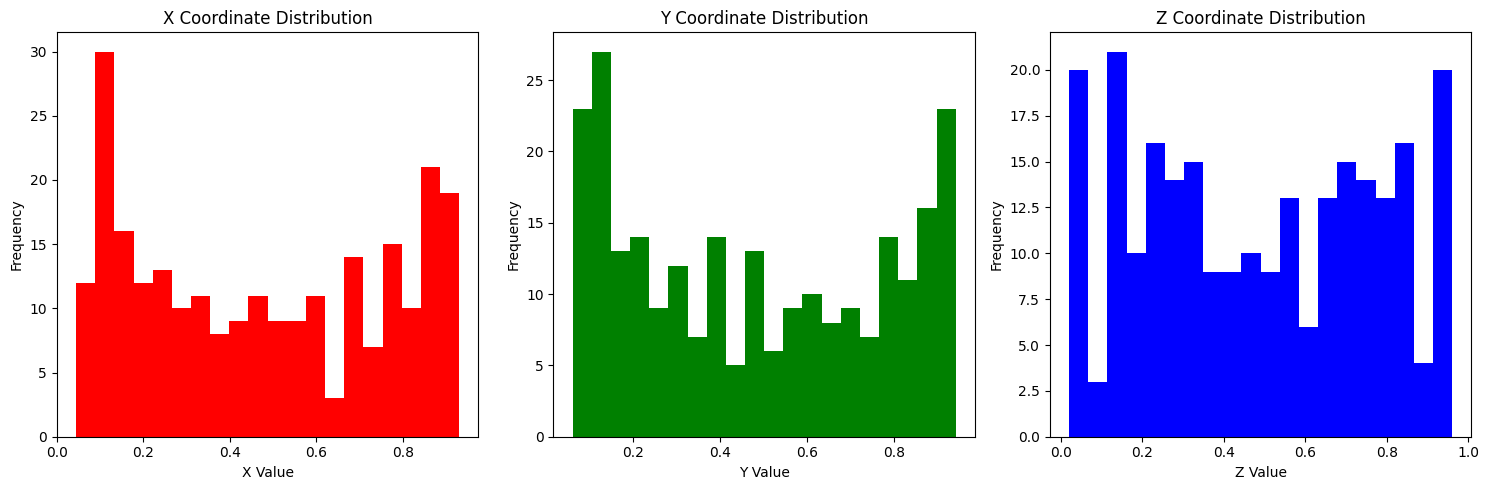

✅ Generation complete. Saved files:
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_51.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_52.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_53.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_54.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_55.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_56.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_57.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_58.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_59.npy
 • /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/PC_Polysurface_60.npy


In [107]:


# -------- settings --------
num_new_pointclouds = 10      #@param {type: "number"}

num_to_preview = 5            #@param {type: "number"}

# -------- helpers --------
def next_file_index(directory: str, stem: str) -> int:
    """Find next numeric index for files like '{stem}_####.npy'."""
    if not os.path.exists(directory):
        return 0
    pat = re.compile(rf"^{re.escape(stem)}_(\d+)\.npy$")
    max_idx = -1
    for fname in os.listdir(directory):
        m = pat.match(fname)
        if m:
            max_idx = max(max_idx, int(m.group(1)))
    return max_idx + 1

@torch.no_grad()
def decode_from_latent(model, z: torch.Tensor, num_points: int) -> torch.Tensor:
    """Decode latent z → (B, 3, N) point clouds (on CPU)."""
    model.eval()
    device = next(model.parameters()).device
    B = z.shape[0]
    queries = make_point_queries(num_points, B, dim=hp.query_dim, device=device)  # (B, N, qdim)
    pts = model.decoder(z.to(device), queries)    # (B, N, 3)
    return pts.transpose(1, 2).contiguous().cpu() # (B, 3, N)

# -------- generation --------
print(f"Generating {num_new_pointclouds} point clouds with N={number_of_pc_points} points each.")

os.makedirs(save_geo_path, exist_ok=True)
start_idx = next_file_index(save_geo_path, save_geo_name)

device = next(model.parameters()).device
latent_dim = hp.latent_dim
cur_idx = start_idx
saved_paths = []
previewed = 0

batch_size = 64
remaining = num_new_pointclouds

while remaining > 0:
    b = min(batch_size, remaining)
    z = torch.randn(b, latent_dim, device=device)
    pcs = decode_from_latent(model, z, number_of_pc_points)  # (B, 3, N) on CPU

    for i in range(b):
        arr = pcs[i].numpy()
        fname = f"{save_geo_name}_{cur_idx}.npy"
        fpath = os.path.join(save_geo_path, fname)
        np.save(fpath, arr)
        saved_paths.append(fpath)

        # visualize some of the new samples
        if previewed < num_to_preview:
            print(f"[Preview {previewed+1}] {fname}")
            pc_t = torch.from_numpy(arr)
            visualize_point_cloud(pc_t,  color="black")
            plot_point_cloud_histograms(pc_t,)
            previewed += 1

        cur_idx += 1

    remaining -= b

print("✅ Generation complete. Saved files:")
for p in saved_paths:
    print(" •", p)
